In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json
from tqdm.auto import tqdm
from src.utils.sweep_utils import read_sweep_results, relation_from_dict
import pandas as pd

In [3]:
############################################
sweep_root = "../../results/sweep-24-trials"
model_name = "gptj"
############################################

sweep_path = f"{sweep_root}/{model_name}"

In [4]:
sweep_results = read_sweep_results(sweep_path)
list(sweep_results.keys())

--> ../../results/sweep-24-trials/gptj
    --> ../../results/sweep-24-trials/gptj/person_occupation
        --> ../../results/sweep-24-trials/gptj/person_occupation/1_person_occupation_seed_71745
            --> ../../results/sweep-24-trials/gptj/person_occupation/1_person_occupation_seed_71745/results_all.json
            --> ../../results/sweep-24-trials/gptj/person_occupation/1_person_occupation_seed_71745/person_occupation.json
            --> ../../results/sweep-24-trials/gptj/person_occupation/1_person_occupation_seed_71745/args-20230606-211709.json
        --> ../../results/sweep-24-trials/gptj/person_occupation/3_person_occupation_seed_709106
            --> ../../results/sweep-24-trials/gptj/person_occupation/3_person_occupation_seed_709106/args-20230607-012240.json
            --> ../../results/sweep-24-trials/gptj/person_occupation/3_person_occupation_seed_709106/results_all.json
            --> ../../results/sweep-24-trials/gptj/person_occupation/3_person_occupation_seed_70

['person occupation',
 'landmark in country',
 'adjective antonym',
 'person mother',
 'country capital city',
 'plays pro sport',
 'person plays instrument',
 'person university',
 'city in country',
 'food from country',
 'company hq',
 'occupation age',
 'word first letter',
 'country language',
 'object superclass',
 'name religion',
 'person native language',
 'fruit outside color',
 'superhero archnemesis',
 'work location',
 'landmark on continent',
 'person lead singer of band',
 'task person type',
 'country largest city',
 'country currency',
 'fruit inside color',
 'task done by tool',
 'verb past tense',
 'star constellation name',
 'pokemon evolution',
 'product by company',
 'name birthplace',
 'word last letter',
 'word sentiment',
 'company CEO',
 'superhero person',
 'person father',
 'substance phase of matter',
 'person sport position',
 'adjective superlative',
 'adjective comparative',
 'univ degree gender']

In [5]:
dataset = data.load_dataset()
interested_dataset = dataset.filter(
    # relation_type = ["factual"]
)

filtered_results = {}
for relation in tqdm(interested_dataset.relations):
    if relation.name not in sweep_results:
        continue
    relation_result = relation_from_dict(sweep_results[relation.name])
    if len(relation_result.trials) < 3:
        print(f"skipping {relation.name}, not enough trials, : {[trial.n_test_samples for trial in relation_result.trials]}")
        continue
    filtered_results[relation.name] = relation_result

  0%|          | 0/47 [00:00<?, ?it/s]

skipping occupation age, not enough trials, : [23]


In [37]:
##################
beta = 0.4000000059604645
###################
beta = None

In [38]:
table = []
dataset = data.load_dataset()

for relation_name, sweep_result in filtered_results.items():
    efficacy_hparams = sweep_result.best_by_efficacy(beta=beta)
    relation = dataset.filter(
        relation_names=[relation_name]
    )[0]
    table.append({
        "relation": relation_name,
        "recall": f"{efficacy_hparams.recall.mean: .2f} ± {efficacy_hparams.recall.stdev: .2f}",
        "beta": f"{efficacy_hparams.beta.mean: .2f} ± {efficacy_hparams.beta.stdev: .2f}",
        "efficacy": f"{efficacy_hparams.efficacy.mean: .2f} ± {efficacy_hparams.efficacy.stdev: .2f}",
        "rank": f"{efficacy_hparams.rank.mean: .2f} ± {efficacy_hparams.rank.stdev: .2f}",
        "n_range": f"{len(relation.range)}",
    })

In [39]:
sorted_table = sorted(table, key=lambda x: x["efficacy"], reverse=True)

In [40]:
df = pd.DataFrame(sorted_table)
os.makedirs("../../results/tables", exist_ok=True)
df.to_csv(f"../../results/tables/{model_name}-beta-grid.csv", index=False)
print(df.to_markdown(index = False, tablefmt="github"))

| relation                   | recall       | beta         | efficacy     | rank            |   n_range |
|----------------------------|--------------|--------------|--------------|-----------------|-----------|
| name religion              | 0.95 ±  0.05 | 0.26 ±  0.09 | 0.99 ±  0.02 | 49.55 ±  54.81  |         5 |
| adjective superlative      | 0.94 ±  0.02 | 0.44 ±  0.05 | 0.99 ±  0.01 | 148.75 ±  23.15 |        79 |
| country currency           | 0.65 ±  0.08 | 0.34 ±  0.08 | 0.98 ±  0.03 | 76.67 ±  31.84  |        23 |
| country language           | 0.95 ±  0.05 | 0.30 ±  0.07 | 0.98 ±  0.03 | 63.75 ±  34.98  |        14 |
| country largest city       | 0.95 ±  0.06 | 0.20 ±  0.08 | 0.98 ±  0.03 | 68.75 ±  53.41  |        24 |
| verb past tense            | 0.97 ±  0.02 | 0.36 ±  0.11 | 0.98 ±  0.01 | 135.42 ±  39.47 |        76 |
| country capital city       | 0.95 ±  0.05 | 0.19 ±  0.13 | 0.97 ±  0.04 | 52.92 ±  31.02  |        24 |
| substance phase of matter  | 0.96 ±  0.03 | 

univ degree gender 38 2 113.75
name birthplace 31 8 72.08
name religion 31 5 49.55
person native language 919 30 120.0
fruit inside color 36 6 119.52
fruit outside color 30 9 89.38
object superclass 76 10 74.17
substance phase of matter 50 3 78.33
task person type 32 32 136.67
task done by tool 52 51 114.58
word sentiment 60 3 66.67
work location 38 24 123.75
city in country 27 21 116.67
company CEO 298 287 156.67
company hq 674 163 122.5
country capital city 24 24 52.92
country currency 30 23 76.67
country language 24 14 63.75
country largest city 24 24 68.75
food from country 30 26 88.75
landmark in country 836 91 138.18
landmark on continent 947 5 143.64
person lead singer of band 21 21 148.75
person father 1000 977 209.17
person mother 1000 968 166.67
person occupation 821 31 155.0
person plays instrument 513 6 161.67
person sport position 952 14 60.83
plays pro sport 318 5 82.5
person university 91 69 107.08
pokemon evolution 44 44 183.33
product by company 522 30 171.25
star cons

Text(0, 0.5, 'rank')

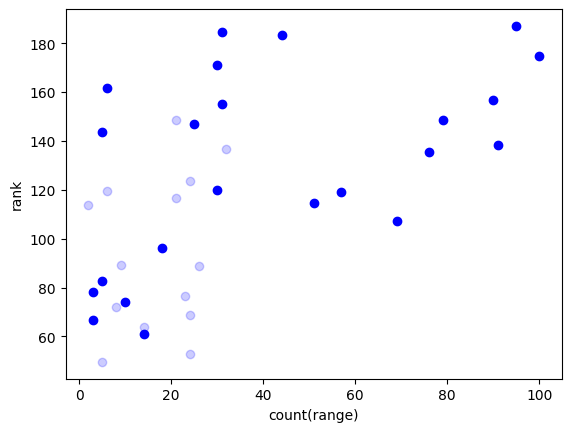

In [52]:
ranks = [float(rank.split("±")[0].strip()) for rank in df["rank"]]
n_range = [int(rng) for rng in df["n_range"].values]

for results in table:
    rank = float(results["rank"].split("±")[0].strip())
    rng = int(results["n_range"])
    relation = dataset.filter(
        relation_names=[results["relation"]]
    )[0]
    print(relation.name, len(relation.samples), rng, rank)
    if(rng < 140):
        alpha = 1
        if len(relation.samples) < 40:
            alpha = 0.2
        plt.scatter(rng, rank, color="blue", alpha=alpha)

plt.xlabel("count(range)")
plt.ylabel("rank")